### Config the model

In [28]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
# output=model.invoke("hi")
# print(output.content)
model="deepseek-r1-distill-llama-70b"
from langchain_groq import ChatGroq
llm = ChatGroq(model_name=model,temperature=0)
llm.invoke("hi")
print(llm.invoke("hi").content)

<think>

</think>

Hello! How can I assist you today? 😊


### Config the embedding model

In [29]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

### Creating the agent

In [30]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END, START
from langchain.output_parsers import PydanticOutputParser
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS



In [31]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [32]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [33]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    retries: int

In [34]:
def function_1(state:AgentState):
    
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following related categories: [Constitution,LLM, Latest]. If question is about 
    Indian constitution then Constitution, if question is generic then LLM and if question is about some recent thing which you don't know then Latest.
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | llm | parser
    
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [35]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "constitution" in last_message.lower():
        return "RAG Call"
    elif "latest" in last_message.lower():
        return "WEB Call"
    else:
        return "LLM Call"

In [36]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [37]:
# Load a PDF and validate the page count
file_path = r"C:\Users\saina\Desktop\DS_ML_AI\Krish_Naik_Courses\Krish_naik_1_Agentic_AI_and_Gen_AI\Practice\agentic_ai_2\data\2023050195.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load()

#Using semantic chunking with recursive text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(pages)


# Hugging Face embedding
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

faiss_flat = FAISS.from_documents(chunks, embedding_model)
retriever_flat = faiss_flat.as_retriever()

In [38]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever_flat | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [39]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Answer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [40]:
from langchain_community.tools import DuckDuckGoSearchRun
def search_fun(state:AgentState):
    search=DuckDuckGoSearchRun()
    result = search.invoke({"query":state["messages"][0]})
    return {"messages": [result]}


In [51]:
def function_4(state:AgentState):
    
    question = state["messages"][0]
    answer=state["messages"][-1]
    
    print("answer",answer)
    
    template="""
    Your task is to check if the response is related to the user question and if you think answer is completed say yes or else say no. 
    Only respond with yes or no and nothing else.

    User query: {question}
    response: {answer}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question","answer"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | llm | parser
    
    response = chain.invoke({"question":question,"answer":answer})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [42]:
# def router_1(state:AgentState):
#     print("-> ROUTER_1 ->")
    
#     last_message=state["messages"][-1]
#     print("last_message:", last_message)
    
#     if "yes" in last_message.lower():
#         return "yes"
#     else:
#         return "no"

# Modify router_1 to check retries
def router_1(state: AgentState):
    print("-> ROUTER_1 ->")
    if state["retries"] >= 2:
        return "yes"  # Stop looping
    if "yes" in state["messages"][-1].lower():
        return "yes"
    else:
        state["retries"] += 1
        return "no"

In [58]:
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("WEB", search_fun)
workflow.add_node("VALIDATION",function_4)
workflow.set_entry_point("Supervisor")

In [59]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "WEB Call": "WEB",
    }
)

In [60]:
workflow.add_edge("RAG","VALIDATION")
workflow.add_edge("LLM","VALIDATION")
workflow.add_edge("WEB","VALIDATION")

workflow.add_conditional_edges(
    "VALIDATION",
    router_1,
    {
        "yes": END,
        "no":"Supervisor"
    }

)

In [61]:
app=workflow.compile()

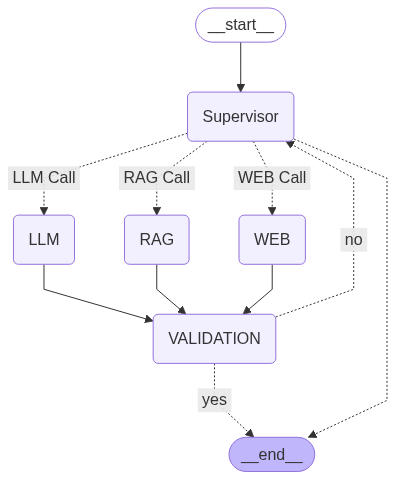

In [62]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [63]:
# Initialize state
state = {"messages": ["List all the fundamental rights"], "retries": 0}
app.invoke(state)

Question List all the fundamental rights
Parsed response: Topic='Constitution' Reasoning='The query asks about the fundamental rights, which are part of the Indian Constitution.'
-> ROUTER ->
last_message: Constitution
-> RAG Call ->
answer <think>
Okay, so I need to figure out how to answer the question "List all the fundamental rights" using the provided context. Let me start by reading through the context carefully.

The context is from the Indian Constitution, specifically Part III which deals with Fundamental Rights. I see that it's divided into several sections: General, Right to Equality, Right to Freedom, Right against Exploitation, and Right to Constitutional Remedies.

Looking at the General section, there are Articles 12 and 13. Article 12 defines what "the State" includes, and Article 13 talks about laws inconsistent with fundamental rights. These are more about definitions and laws rather than specific rights.

Next, under Right to Equality, the articles listed are 14, 15,

OutputParserException: Invalid json output: The response provided lists all the fundamental rights as per the given context, so the answer is complete.

yes
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 

In [48]:
# Initialize state
state = {"messages": ["How to make black tea?"], "retries": 0}
app.invoke(state)

Question How to make black tea?
Parsed response: Topic='LLM' Reasoning='The question is about making black tea, which is a generic topic and does not relate to the Indian Constitution or recent events.'
-> ROUTER ->
last_message: LLM
-> LLM Call ->
answer <think>
Okay, so I want to figure out how to make black tea. I've seen people do it before, but I'm not exactly sure about the steps. Let me think through this.

First, I know that black tea is a type of tea, and it's different from green or herbal teas. I remember that black tea is fermented, which probably means it's processed differently. But how does that affect the brewing process?

I think the basic process involves boiling water, putting tea leaves in, and letting it steep. But I'm not sure about the details. How much water? How much tea? How long should it steep?

I've heard that the quality of the water matters. Maybe it's best to use fresh, filtered water to avoid any odd tastes. Also, the temperature might be important. I t

OutputParserException: Invalid json output: <think>
Okay, so I need to figure out how to make black tea. I've heard it's different from green tea, but I'm not exactly sure how. Let me start by recalling what I know about tea in general.

First, I know that tea comes from the Camellia sinensis plant, and the main types are black, green, white, oolong, and herbal. Black tea is one of the most common types. I think the difference between black and green tea is in the processing. Green tea is steamed or pan-fried to stop fermentation, while black tea is allowed to ferment, which changes the flavor and color.

So, to make black tea, I probably need to use boiling water. I remember that green tea sometimes uses slightly cooler water to prevent bitterness, but black tea can handle boiling water. That makes sense because of the fermentation process.

Next, I need to consider the tea leaves. Should I use loose-leaf or tea bags? I think both are fine, but loose-leaf might give a better flavor. How much tea should I use? I've heard about the rule of one teaspoon per cup, but I'm not sure if that's for loose-leaf or tea bags. Maybe it's the same.

Then, there's the steeping time. I think black tea needs to steep longer than green tea. Maybe around 3 to 5 minutes? If I steep it too long, it might become bitter, so I should be careful with the timing.

I also remember that some people add milk or sugar to their black tea. I'm not sure if that's a traditional thing or just personal preference. Maybe I can try it both ways to see which I like better.

I'm also wondering about the vessel. Should I use a teapot or just a mug? I think a teapot is better because it allows the leaves to unfurl properly, but a mug with a tea infuser should work too.

Oh, and what about reusing the tea leaves? I think black tea is usually made with one infusion, but I'm not entirely sure. Maybe some people do multiple steepings, but I'll start with one and see how it goes.

So, putting it all together, the steps would be: boil water, warm the teapot, add tea leaves, pour in the water, steep for a few minutes, strain, and then add any desired milk or sweeteners.

I should also think about common mistakes. Using water that's too hot might burn the leaves, but I think black tea can handle boiling water. Not steeping long enough might make it too weak, and steeping too long could make it bitter.

I'm not entirely sure about the exact measurements, but I think starting with one teaspoon per cup is a good rule of thumb. Adjusting from there based on personal taste makes sense.

Overall, the process seems straightforward, but getting the details right can make a big difference in the taste. I should try it out and see how it goes, maybe tweak the steeping time or the amount of tea next time based on how it turns out.

I wonder if the type of black tea affects the brewing process. For example, Earl Grey has bergamot oil, but I don't think that changes how you brew it. Maybe some teas are more delicate than others, so steeping time might vary slightly.

Also, I'm curious about the water quality. Using fresh, filtered water is probably important to avoid any impurities affecting the taste. Tap water might have minerals that change the flavor, so using filtered water could make the tea taste better.

Another thing to consider is the size of the tea leaves. Finer leaves might steep faster than larger ones, so the steeping time could be shorter. I should pay attention to that if I'm using different types of tea leaves.

I think I've covered the basics. Now, I'll try to make a cup of black tea using these steps and see how it turns out. If it's too strong or too weak, I'll adjust the next time. Practice makes perfect, right?
</think>

To make black tea, follow these organized steps for an optimal brewing experience:

1. **Boil Water**: Use fresh, filtered water and bring it to a boil (around 200°F to 212°F), suitable for black tea.

2. **Warm the Teapot**: Swirl a small amount of hot water in the teapot to warm it, ensuring even heat distribution.

3. **Add Tea Leaves**: Use 1 teaspoon of loose-leaf black tea per 8 oz of water. If using tea bags, one bag per cup is sufficient. Adjust the amount based on your preference for strength.

4. **Steep the Tea**: Pour the boiling water over the tea leaves and let it steep for 3 to 5 minutes. Adjust the time to avoid bitterness.

5. **Strain and Serve**: If using loose-leaf, strain the leaves into another pot or directly into the cup. For tea bags, remove the bag after steeping.

6. **Customize to Taste**: Add milk, sugar, or honey as desired. Traditional additions vary, so personalize according to your preference.

7. **Consider the Vessel**: Use a teapot for optimal infusion, but a mug with a tea infuser works well too.

8. **Experiment**: Adjust steeping time, tea quantity, and additions based on personal taste. Some teas may allow multiple steepings, though black tea is usually enjoyed with one infusion.

Enjoy your perfectly brewed black tea!
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 